# Training model

In [1]:
#Import Packages
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import tqdm

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

df = pd.read_csv('Boliga - Final for training.csv')
df = df.drop(columns = ['Kommune'])
df = df.sample(20000)

In [2]:
#Split into X and Y 
df_dum = pd.get_dummies(df, drop_first = True, columns = ['isForeclosure', 'Type'])
X = df_dum.drop(columns = ['price'])
y = df_dum['price']

In [3]:
pd.options.display.max_columns = 100
X.head()

basementSize  buildYear  Ejerudgift  lotSize  rooms  size  \
47622             0          0        1680      838    0.0     0   
7280            113       1930       12823     1275    6.0   264   
11425             0       1902        2585      801    4.0   141   
1871              0       1920        4415        0    4.0   110   
26924            80       1966        1991      962    6.0   164   

       Relativ Ledighed  Grundskole  Gymnasiale uddannelser  \
47622          5.606889   17.010018                4.203878   
7280           5.450847    7.842203                8.774159   
11425          4.911129   13.207296                5.613988   
1871           7.926682   13.754726                7.646977   
26924          6.682590   21.352085                3.774225   

       Erhvervsfaglige uddannelser       KVU        MVU  Bacheloruddannelser  \
47622                    39.575011  6.943718  20.268546             1.190053   
7280                     16.558115  5.501721  19.020387             3.478952   
11425                    39.786092  8.139174  18.288732             1.544402   
1871                     19.268325  4.928181  17.977495             3.627649   
26924                    44.291532  6.149612  17.042455             0.938843   

             LVU  Kommunal_gennemsnitsinkomst_2017  Total_reported  \
47622   8.957815                            325198        0.577769   
7280   34.034948                            583331        0.867364   
11425  11.059335                            371405        0.437960   
1871   26.658495                            319745        0.188050   
26924   5.271096                            288458        0.562362   

       Population_in_urban_development  Socioeconomic_index  \
47622                             80.7                 0.67   
7280                              99.9                 1.21   
11425                             94.3                 0.53   
1871                             100.0                 1.08   
26924                             71.3                 0.94   

       expenses_per_school_student  average_class_size  \
47622                        64695                22.1   
7280                         73961                21.7   
11425                        81243                22.3   
1871                         69710                22.8   
26924                        62486                20.7   

       expenses_sport_and_other_cultural_activities  lake_distance  \
47622                                          1227        0.91330   
7280                                           1832        3.88295   
11425                                          1016        3.02247   
1871                                           1062        0.44908   
26924                                          1207        3.32188   

       forest_distance  doctor_distance  supermarket_distance  \
47622          1.08407          2.44791               1.60696   
7280           1.71384          0.64624               1.33297   
11425          0.40187          1.66961               1.48234   
1871           6.38122          0.38845               0.55032   
26924          1.60319          0.45239               0.47161   

       school_distance  daycare_distance  hospital_distance  train_distance  \
47622          1.38768           0.59342            3.80747         2825.63   
7280           0.49443           0.50650            5.13768          841.16   
11425          1.80542           1.51785           11.25191        12462.71   
1871           0.41134           0.23137            0.53435         1493.26   
26924          0.99937           0.70827           15.83932          378.45   

       pharmacy_distance  library_distance  coast_distance  junction_distance  \
47622            2.56677           2.93589        44.58902            3.52939   
7280             1.57455           1.93563         0.74899            5.23719   
11425            1.67743           1.73512         7.70663 

### Split data into Test, Development, Validation and Train

In [4]:
from sklearn.model_selection import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.5, random_state = 1)

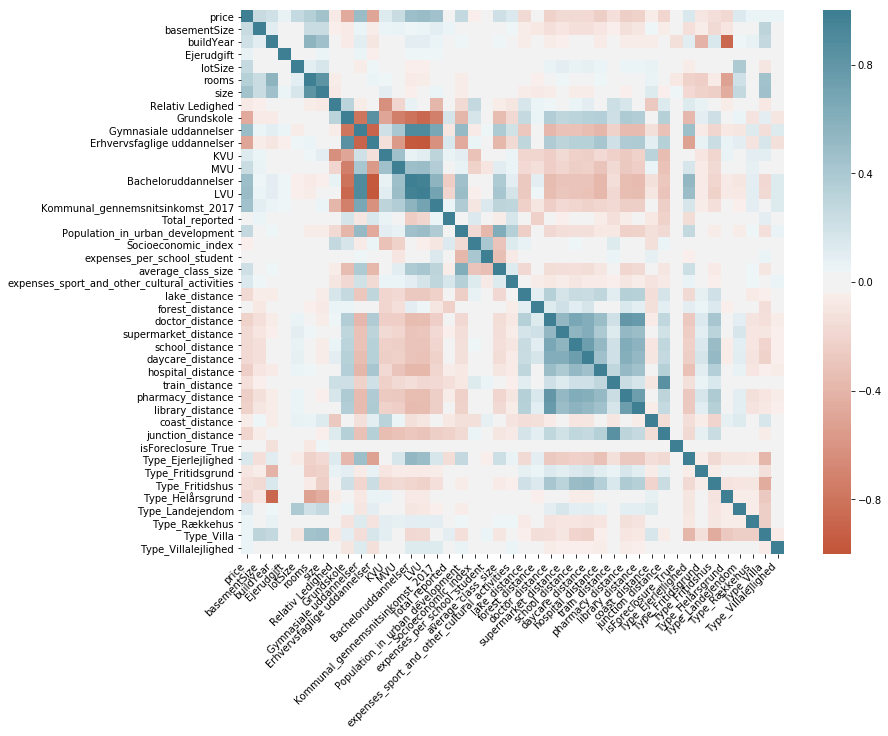

In [5]:

corr = df_dum.corr()
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

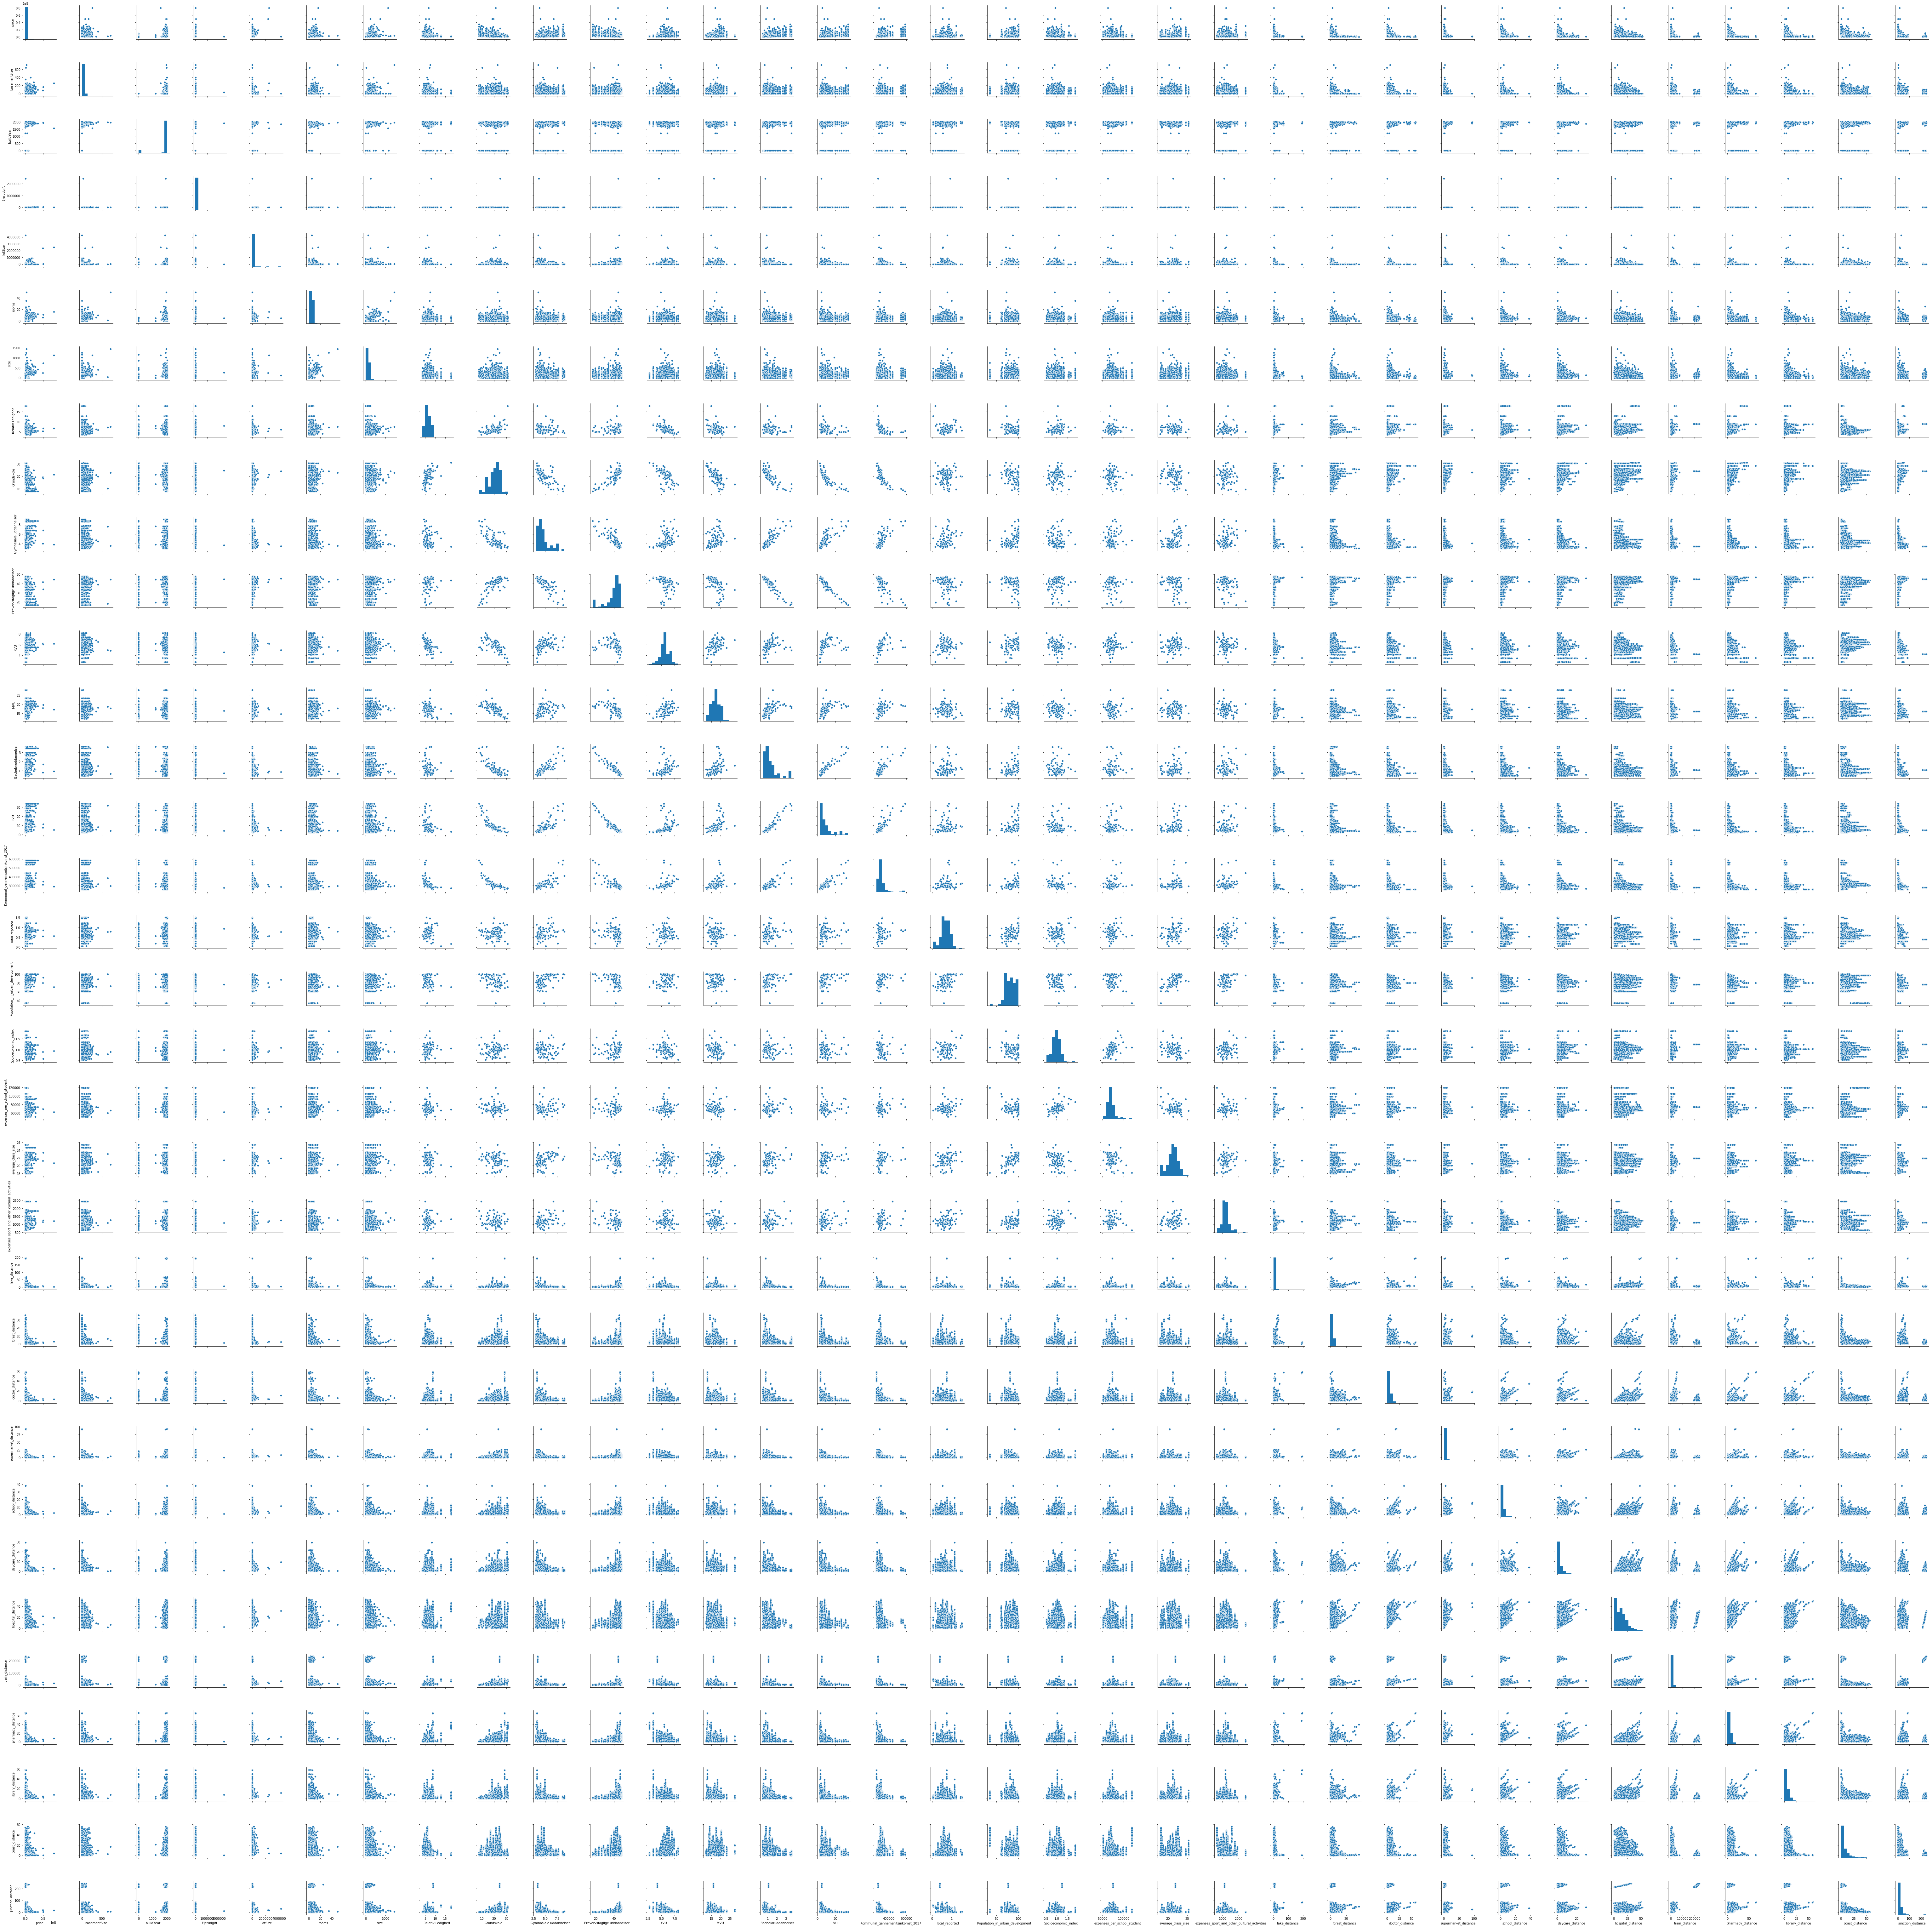

In [7]:
g = sns.pairplot(df.drop(columns = ['isForeclosure', 'Type']))

In [10]:
df['Ejerudgift'].max()

2443216

### Scale, fit and transform data

In [8]:
from sklearn.preprocessing import StandardScaler

#stdscale = StandardScaler(with_mean = 1, with_std = True)

#Scale explanatory variables
#X_train_s = stdscale.fit_transform(X_train)
#X_test_s = stdscale.transform(X_test)


#Scale target variable (because of regression model - no need when categorical)
#y_train_s = stdscale.fit_transform(y_train)
#y_test_s = stdscale.transform(y_test)


### Optimize hyperparameter with K-fold CV 

In [9]:
#Find optimized lambda
from sklearn.model_selection import KFold

lambdas =  np.logspace(-4, 4, 12) # define lambda - devide into 12 lambdas between 10**-4 and 10**4
kfolds = KFold(n_splits=5) # define nr. of folds

#Creates lists to append values of the loop:
mse_val_avr = []
mse_test_avr = []
lambda_list = []

#Outer-loop (Lambdas)
for lambda_ in tqdm.tqdm(lambdas):
#Inner-loop (Folds)
    mse_val_ = []
    mse_test_ = []
    #Split the dataset into 5 folds, and loop through each fold. 
    # In the iteration, the fold in question acts as the training-set. 
    for train_idx,val_idx in kfolds.split(X_dev, y_dev):
    # train model and compute MSE on test fold
        pipe_Lasso_CV = make_pipeline(PolynomialFeatures(include_bias=False, degree = 3), 
                        StandardScaler(with_mean = 1, with_std = True ),
                        Lasso(alpha = lambda_, random_state=1))
        # Assign X_train & y_train by extracting elements if the folds from X_dev and y_dev
        X_train2, y_train2 = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        # Assign X_val & y_val by extracting elements of the folds from X_dev and y_dev
        X_val2, y_val2 = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        # Fit Lasso-model to training data
        pipe_Lasso_CV.fit(X_train2, y_train2)   
        #Calculate and append the mse into mse_val list:
        mse_val_.append(mse(pipe_Lasso_CV.predict(X_val2), y_val2))
        ##Calculate and append the mse into mse_test list:
        mse_test_.append(mse(pipe_Lasso_CV.predict(X_test), y_test))
        
    mse_val_avr.append(sum(mse_val_)/len(mse_val_))
    mse_test_avr.append(sum(mse_val_)/len(mse_val_))
    #mse_val.append(mse_val_)
    #mse_test.append(mse_test_)

df_val = pd.DataFrame(mse_val_avr, index = lambdas)
df_test = pd.DataFrame(mse_test_avr, index = lambdas)
df_join = pd.concat([df_test, df_val], axis=1)
df_with_index = df_join.reset_index()

#Convert to list
mses = df_with_index.values.tolist()


  0%|          | 0/12 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. Yo

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
 50%|█████     | 6/12 [1:08:21<1:08:17, 682.91s/it]/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
100%|██████████| 12/12 [2:03:48<00:00, 523.39s/it]


In [11]:
pd.options.display.float_format = "{:.2f}".format

In [12]:
df_join

0                       0
0.00     35060565286792626176.00 35060565286792626176.00
0.00     35060600226915627008.00 35060600226915627008.00
0.00     35060790820723720192.00 35060790820723720192.00
0.02     35061824185560182784.00 35061824185560182784.00
0.08     35067519024632684544.00 35067519024632684544.00
0.43     35100407805438832640.00 35100407805438832640.00
2.31     35177995174527610880.00 35177995174527610880.00
12.33    34182909742055219200.00 34182909742055219200.00
65.79    29332561969823260672.00 29332561969823260672.00
351.12   88185084926617763840.00 88185084926617763840.00
1873.82   1447199402886136576.00  1447199402886136576.00
10000.00      680137145352558.88      680137145352558.88